# Imports

In [1]:
import os
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import astropy.units as u
from astropy.io import fits
from astropy.table import Table

from gammapy.utils.energy import EnergyBounds
from gammapy.irf import EffectiveAreaTable, EnergyDispersion2D 

from protopipe.pipeline.utils import load_config
from gammapy.spectrum import CrabSpectrum
from gammapy.spectrum.models import PowerLaw

/Users/julien/anaconda2/envs/cta_pipeline/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Functions

In [2]:
def plot_table(ax, t, colname, label, **kwargs):
    centers = np.sqrt(t['ENERG_LO'] * t['ENERG_HI'])
    bin_width = t['ENERG_HI'] - t['ENERG_LO']
    err_plus = t['ENERG_HI'] - centers
    err_minus = centers - t['ENERG_LO']
    values = t[colname]
    ax.errorbar(centers, values, xerr=(err_minus,err_plus), label=label, **kwargs)
    return ax

def plot_energy_response(ax, rmf, label, **kwargs):
    energy = rmf.e_true.nodes
    bias = rmf.get_bias(energy)
    resol = rmf.get_resolution(energy)
    ax.errorbar(energy.value, bias, **kwargs, ls='--')
    ax.errorbar(energy.value, resol, label=label, **kwargs, ls='-')
    return ax

def plot_irf(axes, perf, label, **kwargs):
    plot_table(axes[0], perf['bkg'], 'BGD', label=label, **kwargs)
    plot_table(axes[1], perf['aeff'], 'SPECRESP', label=label, **kwargs)
    plot_table(axes[2], perf['psf'], 'PSF68', label=label, **kwargs)
    plot_energy_response(axes[3], perf['rmf'], label, **kwargs)
    
    axes[0].set_xlabel('Reco energy [TeV]')
    axes[0].set_ylabel('Background rate [Hz]')
    axes[0].set_yscale('log')

    axes[1].set_xlabel('True energy [TeV]')
    axes[1].set_ylabel('Effective area [m2]')
    axes[1].set_yscale('log')
    
    axes[2].set_xlabel('Reco energy [TeV]')
    axes[2].set_ylabel('Point spread function (68%) [deg]')
    axes[2].set_ylim([0., 0.5])

    axes[3].set_xlabel('True energy [TeV]')
    axes[3].set_ylabel('Energy dispersion [%]')
    axes[3].set_ylim([-0.05, 0.85])
    
    plt.tight_layout()
    
def get_performance(filename):
    with fits.open(filename, memmap=False) as hdulist:
        aeff = EffectiveAreaTable.from_hdulist(hdulist=hdulist).to_table()
        bkg = Table.read(hdulist["BACKGROUND"])
        psf = Table.read(hdulist["POINT SPREAD FUNCTION"])
        sens = Table.read(hdulist["SENSITIVITY"])
        edisp = EnergyDispersion2D.read(filename, hdu="ENERGY DISPERSION")
        rmf = edisp.to_energy_dispersion(offset=0.5 * u.deg)

    perf = dict(aeff= aeff, bkg= bkg, psf= psf, rmf=rmf, sens=sens)
    return perf

def plot_sensitivity(ax, t, label, **kwargs):
    plot_table(ax=ax, t=t, colname='SENSITIVITY', label=label, **kwargs)
    return ax

def plot_sensitivity_residuals(ax, table_sens, table_ref, **kwargs):
    emin = table_ref['ENERG_LO'][0]
    emax = table_ref['ENERG_HI'][-1]
    t = table_sens[(table_sens['ENERG_LO'] >= 0.99 * emin) & (table_sens['ENERG_HI'] <= 1.01 * emax)]
    
    t_ratio = Table()
    t_ratio['ENERG_LO'] = t['ENERG_LO'].data
    t_ratio['ENERG_HI'] = t['ENERG_HI'].data
    t_ratio['RATIO'] = (1. - (t['SENSITIVITY'] / table_ref['SENSITIVITY']))
    
    plot_table(ax=ax, t=t_ratio, colname='RATIO', label=None, **kwargs)
    return ax

def plot_crab(ax, fraction):
    crab_model = CrabSpectrum('hegra').model
    reference = 1 * u.TeV
    amplitude = crab_model(energy=reference) * fraction
    index = CrabSpectrum('hegra').model.parameters['index'].value
    energy = np.logspace(-2, 2, 100) * u.TeV
    flux = PowerLaw(amplitude=amplitude, reference=reference, index=index)(energy)
    e2flux = (flux * energy **2) * u.TeV.to('erg')
    ax.plot(energy.value, e2flux.value, ls='--', lw=2, color='grey', alpha=0.5)
    
def plot_sensitivity_comparison(list_perf, list_label, list_color, perf_ref, config, title):
    fig = plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(5, 1, hspace=0.05)
    ax_sens = plt.subplot(gs[:-1, :])
    ax_res = plt.subplot(gs[4, :])

    emin = perf_ref[config]['sens']['ENERG_LO'][0]
    emax = perf_ref[config]['sens']['ENERG_HI'][-1]
    sens_list = []
    for perf in list_perf:
        sens_table = perf[config]['sens']
        new_t = sens_table[(sens_table['ENERG_LO'] >= 0.99 * emin) & (sens_table['ENERG_HI'] <= 1.01 * emax)]
        sens_list.append(new_t)
    
    for idx, sensi in enumerate(sens_list):
        plot_sensitivity(
            ax_sens,
            sensi,
            label=list_label[idx],
            **{'color': list_color[idx], 'lw': 2}
        )
        
        plot_sensitivity_residuals(
            ax_res,
            sensi,
            perf_ref[config]['sens'],
            **{'color': list_color[idx], 'lw': 2}
        )
    
    for frac in [0.001, 0.01, 0.1, 1, 10, 100]:
        plot_crab(ax_sens, frac)
    
    sens_min =[sensi['SENSITIVITY'].min() for sensi in sens_list]
    sens_min = min(sens_min)
    
    sens_max =[sensi['SENSITIVITY'].max() for sensi in sens_list]
    sens_max = max(sens_max)
    
    ax_sens.set_xlim([0.03, 12.5])
    ax_sens.set_ylim([sens_min * 0.5, sens_max * 5])
    ax_sens.legend(loc='upper right', fontsize='large')
    ax_sens.set_xlabel('')
    ax_sens.set_xticklabels([])
    ax_sens.grid()
    ax_sens.loglog()
    ax_sens.set_ylabel('Sensitivity [erg / (cm2 s)]')

    ax_res.plot([-1e9, 1e9], [0., 0.], **{'color': 'darkgreen', 'lw': 2})
    ax_res.grid()
    ax_res.set_xscale('log')
    ax_res.set_ylabel('Betterness (%)')
    ax_res.set_xlabel('Reco energy [TeV]')
    ax_res.set_xlim([0.02, 12.5])
    ax_res.set_ylim([-1, 1])

    ## Text for sensitivity
    text = "Obs. time: {}\n".format(config)
    text += "$\\alpha$=0.2 and $\\sigma$=5\n"
    text += "Syst$_{BKG}$=5% and $\\gamma_{min}$=10"
    ax_sens.text(
            0.1, 0.8 , text,
            horizontalalignment='left',
            verticalalignment='bottom',
            multialignment='left',
            bbox=dict(facecolor='white', alpha=1),
            fontsize='large',
            transform=ax_sens.transAxes
    )
    
    ax_sens.set_title(title, fontweight='bold')
    gs.tight_layout(fig)
    return ax_sens, ax_res

# Load IRF from production

In [3]:
# Input directory
indir = '$PROTOPIPE/ana/prod_LSTs/output/perf/'
indir = os.path.expandvars(indir)

# Production of interest
filenames = {'100s': 'irf_tail_ThSq_opti_Time100.00s/irf.fits.gz',
             '30m': 'irf_tail_ThSq_opti_Time0.50h/irf.fits.gz',
             '5h': 'irf_tail_ThSq_opti_Time5.00h/irf.fits.gz',
             '50h': 'irf_tail_ThSq_opti_Time50.00h/irf.fits.gz'}

# Load performance
perf_prod = dict()
for key in filenames.keys():
    perf_prod[key] = get_performance(os.path.join(indir, filenames[key]))

# Load IRF from ASWG

In [4]:
# Input directory
indir = '$GAMMAPY_EXTRA/datasets/cta/irf/prod3/last/CTA-Performance-North-IRFreco1_ROOT_20170627v2_fits/'
indir = os.path.expandvars(indir)
# Production of interest
filenames = {'100s': 'CTA-Performance-North-LST-20deg-N-100s_20170627.fits.gz',
             '30m': 'CTA-Performance-North-LST-20deg-N-30m_20170627.fits.gz',
             '5h': 'CTA-Performance-North-LST-20deg-N-05h_20170627.fits.gz', 
             '50h': 'CTA-Performance-North-LST-20deg-N-50h_20170627.fits.gz'}
perf_evtdisplay = dict()
for key in filenames.keys():
    perf_evtdisplay[key] = get_performance(os.path.join(indir, filenames[key]))
    
indir = '$GAMMAPY_EXTRA/datasets/cta/irf/prod3/last/CTA-Performance-North-IRF-onAxis-reco2_ROOT_20170627_fits/'
indir = os.path.expandvars(indir)
# Production of interest
filenames = {'100s': 'CTA-Performance-North-LST-20deg-N-onaxis-100s_20170627.fits.gz',
             '30m': 'CTA-Performance-North-LST-20deg-N-onaxis-30m_20170627.fits.gz',
             '5h': 'CTA-Performance-North-LST-20deg-N-onaxis-05h_20170627.fits.gz', 
             '50h': 'CTA-Performance-North-LST-20deg-N-onaxis-50h_20170627.fits.gz'}

perf_mars = dict()
for key in filenames.keys():
    perf_mars[key] = get_performance(os.path.join(indir, filenames[key]))

# IRF comparison with EvtDisplay

/Users/julien/anaconda2/envs/cta_pipeline/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


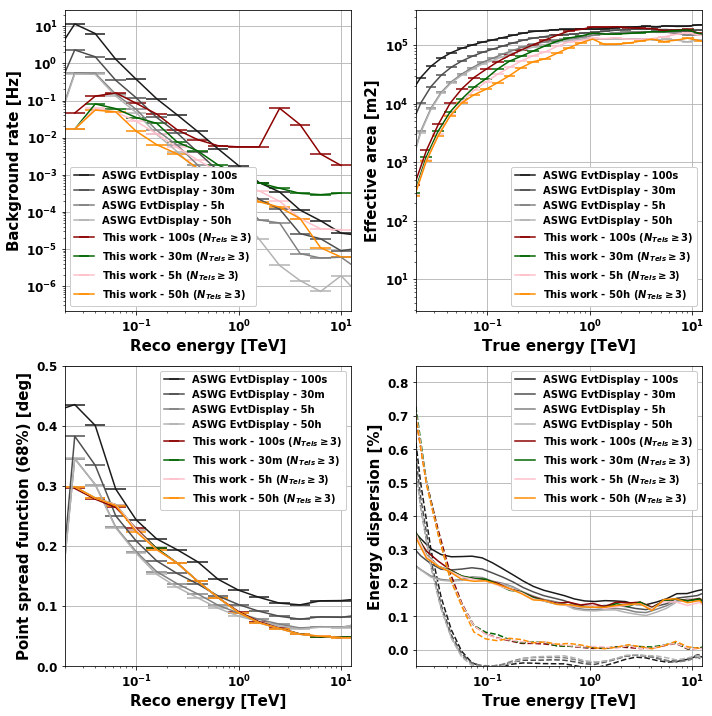

In [5]:
plt.figure(figsize=(10, 10))
ax_bkg = plt.subplot2grid((2, 2), (0, 0))
ax_area = plt.subplot2grid((2, 2), (0, 1))
ax_psf = plt.subplot2grid((2, 2), (1, 0))
ax_resol = plt.subplot2grid((2, 2), (1, 1))
axes = [ax_bkg, ax_area, ax_psf, ax_resol]

plot_irf(axes=axes, perf=perf_evtdisplay['100s'], label="ASWG EvtDisplay - 100s", **{'color': '0.1'})
plot_irf(axes=axes, perf=perf_evtdisplay['30m'], label="ASWG EvtDisplay - 30m", **{'color': '0.3'})
plot_irf(axes=axes, perf=perf_evtdisplay['5h'], label="ASWG EvtDisplay - 5h", **{'color': '0.5'})
plot_irf(axes=axes, perf=perf_evtdisplay['50h'], label="ASWG EvtDisplay - 50h", **{'color': '0.7'})
plot_irf(axes=axes, perf=perf_prod['100s'], label="This work - 100s ($N_{Tels} \geq 3$)", **{'color': 'darkred'})
plot_irf(axes=axes, perf=perf_prod['30m'], label="This work - 30m ($N_{Tels} \geq 3$)", **{'color': 'darkgreen'})
plot_irf(axes=axes, perf=perf_prod['5h'], label="This work - 5h ($N_{Tels} \geq 3$)", **{'color': 'pink'})
plot_irf(axes=axes, perf=perf_prod['50h'], label="This work - 50h ($N_{Tels} \geq 3$)", **{'color': 'darkorange'})

for ax in axes:
    ax.grid()
    ax.legend(loc='best')
    ax.set_xscale('log')
    ax.set_xlim([0.02, 12.5])

# IRF comparison with MARS

/Users/julien/anaconda2/envs/cta_pipeline/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


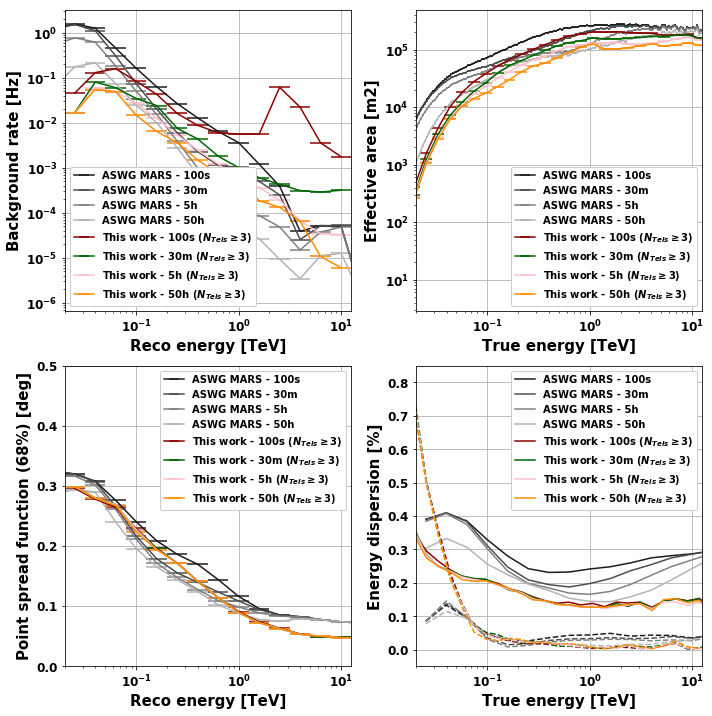

In [12]:
plt.figure(figsize=(10, 10))
ax_bkg = plt.subplot2grid((2, 2), (0, 0))
ax_area = plt.subplot2grid((2, 2), (0, 1))
ax_psf = plt.subplot2grid((2, 2), (1, 0))
ax_resol = plt.subplot2grid((2, 2), (1, 1))
axes = [ax_bkg, ax_area, ax_psf, ax_resol]

plot_irf(axes=axes, perf=perf_mars['100s'], label="ASWG MARS - 100s", **{'color': '0.1'})
plot_irf(axes=axes, perf=perf_mars['30m'], label="ASWG MARS - 30m", **{'color': '0.3'})
plot_irf(axes=axes, perf=perf_mars['5h'], label="ASWG MARS - 5h", **{'color': '0.5'})
plot_irf(axes=axes, perf=perf_mars['50h'], label="ASWG MARS - 50h", **{'color': '0.7'})
plot_irf(axes=axes, perf=perf_prod['100s'], label="This work - 100s ($N_{Tels} \geq 3$)", **{'color': 'darkred'})
plot_irf(axes=axes, perf=perf_prod['30m'], label="This work - 30m ($N_{Tels} \geq 3$)", **{'color': 'darkgreen'})
plot_irf(axes=axes, perf=perf_prod['5h'], label="This work - 5h ($N_{Tels} \geq 3$)", **{'color': 'pink'})
plot_irf(axes=axes, perf=perf_prod['50h'], label="This work - 50h ($N_{Tels} \geq 3$)", **{'color': 'darkorange'})

for ax in axes:
    ax.grid()
    ax.legend(loc='best')
    ax.set_xscale('log')
    ax.set_xlim([0.02, 12.5])

# Sensitivity comparison

(-0.6, 0.6)

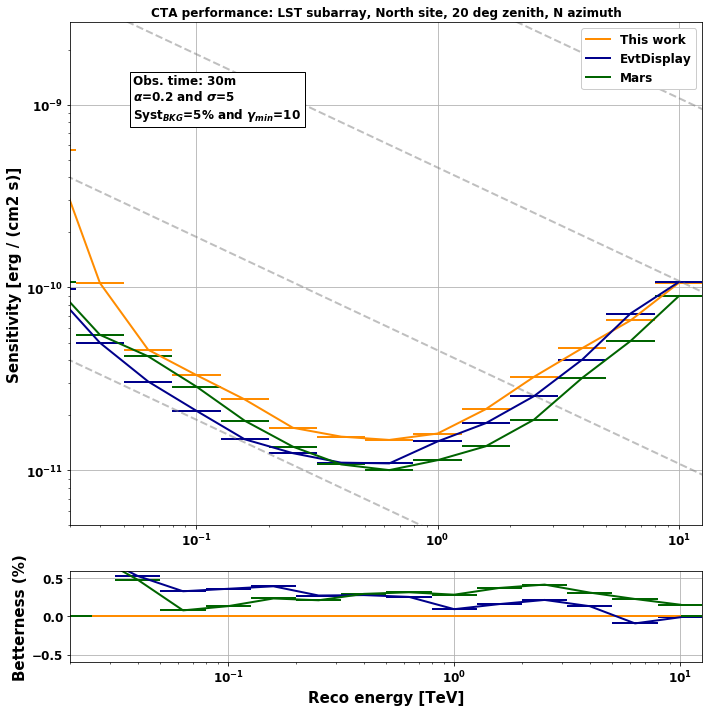

In [10]:
config = '30m'
ax_sens, ax_res = plot_sensitivity_comparison(
    list_perf=[perf_prod, perf_evtdisplay, perf_mars],
    list_label=['This work', 'EvtDisplay', 'Mars'],
    list_color=['darkorange', 'darkblue', 'darkgreen'],
    perf_ref=perf_prod,
    config=config,
    title='CTA performance: LST subarray, North site, 20 deg zenith, N azimuth'
)
ax_res.set_ylim([-0.6, 0.6])